# Chapter 7

## ch7.1
### CNN 개념

- `CNN`은 `컨볼루션 계층`과 `풀링 계층`으로 구성된다.

- 컨볼루션과 풀링 계층은 2차원의 평면 행렬에서 지정한 영역의 값들을 하나의 값으로 압축하는 역할을 한다.

- 단, 압축시에 `컨볼루션 계층`은 가중치와 편향 적용하고, `풀링 계층`은 값들 중 하나를 선택해서 가져옴

- 컨볼루션 계층에서 윈도우 크기만큼의 가중치와 1개의 편향을 적용한다. 윈도우의 크기가 `3x3`이면 `3x3`의 가중체과 `1`개의 편향이 필요하다. 그리고 그 커널은 모든 윈도우에 공통으로 적용된다.

- 입력층이 28x28 개라고 했을 때 기본신경망은 784개의 가중치가 필요하지만, 컨볼루션 계층에서는 9개의 가중치만 찾으면 되므로, 계산량이 매우 적어져 학습이 빠르고 효울적이다.

- 보통 커널을 여러개 사용하며, 커널의 개수는 하이퍼 파라미터이다.

`커널`or`필터` : 위의 예제에서 `3x3`개의 가중치와 `1`개의 편향

## ch7.2
### 모델 구현하기

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# MNIST 데이터 로드
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [3]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # 입력층 [입력데이터개수][28][28][특징의 개수] MNIST 데이터는 회색조 이미지라 채널에 색상이 한개이다.
Y = tf.placeholder(tf.float32, [None, 10]) # 출력 (10개의 분류)
keep_prob = tf.placeholder(tf.float32) # 드롭아웃

 `드롭아웃` : 학습 시 전체 신경망 중 일부만을 사용하도록 하는 것
- 학습 단계마다 일부 뉴런을 제거 함으로써, 일부 특징이 특정 뉴런들에 고정되는 것을 막아 가중치의 균형을 잡도록 하여 과적합을 방지
- 일부 뉴런을 학습시키지 않기 때문에 신경망이 충분히 학습되기까지의 시간은 조금더 오래 걸리는 편

## 첫 번째 계층 생성
### 컨볼루션 계층 만들기
- 입력층 X와 첫번째 계층의 가중치 W1을 가지고, 오른쪽과 아래쪽으로 한 칸씩 움직이는 32개의 커널을 가진 컨볼루션 계층을 만듬

|첫 계층|이미지 입력(X)|3X3 컨볼루션|2X2 풀링|
|-----|---------------|---------------|---------------|
|크기|28X28|28X28X32|14X14X32|
|설명|이미지크기|컨볼루션 결과X커널개수|풀링결과X커널개수|
|이해|MNIST 제공 이미지 크기|3X3`윈도우`가 1칸씩 총 28X28번 이동|2X2에서 하나만 선택 = 14X14의 결과|

In [4]:
W1 = tf.Variable(tf.random_normal([3,3,1,32],stddev=0.01))
L1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME') # padding='SAME' : 이미지의 가장 외곽에서 한칸 밖으로 움직이는 옵션 테두리까지 정확하게 평가가능
L1 = tf.nn.relu(L1)

### 풀링 계층 만들기
- 위의 컨볼루션 계층을 입력층으로 사용하고 커널 크기를 2X2로하는 풀링 계층 생성

In [5]:
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME') #  strides=[1,2,2,1]:슬라이딩시 두칸씩 움직이겠다.

## 두 번째 계층 생성
- 3x3 크기의 커널 64개로 구성한 컨볼루션 계층과 2x2크기의 풀링 계층으로 구성

|두 번째 계층|L1 풀링 특징 맵|L2 컨볼루션(3X3)|L2 풀링(2X2)|
|-----|---------------|---------------|---------------|
|크기|14X14X32|14X14X64|7X7X64|
|설명|L1 풀링의 결과|L2 컨볼루션 결과X커널개수|L2 풀링결과X커널개수|
|이해|첫번째 계층에서 찾은 특징|3X3`윈도우`가 1칸씩 총 14X14번 이동|2X2에서 하나만 선택 = 14X14의 결과|

In [6]:
W2 = tf.Variable(tf.random_normal([3,3,32,64],stddev=0.01)) # 32는 첫 번째 컨볼루션 계층의 커널 개수, 출력층의 개수, 첫번째 컨볼루션 계층이 찾아낸 이미지의 특징 개수
L2 = tf.nn.conv2d(L1,W2,strides=[1,1,1,1],padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')

### 결과 계층 생성
- 10개의 분류를 만들어냄
- 인접한 계층의 모든 뉴런과 상호 연결된 계층을 `완전 연결 계층`이라고 함

|완전 연결 계층|L2 풀링 특징 맵|10개의 분류 계층|
|--------|---------------|---------------|
|크기|7X7X64|7X7X64(1차원)|
|설명|L2 풀링의 결과|L2 컨볼루션 결과X커널개수|
|이해|CNN은 2D평면행렬에서 이루어진다. 첫 시작시 입력데이터의 개수X이미지의 특징개수 인 2차원 평면 행렬로 시작 했다.|10개의 분류는 1차원이므로 차원축소|

In [8]:
W3 = tf.Variable(tf.random_normal([7*7*64,256],stddev=0.01))
L3 = tf.reshape(L2, [-1,7*7*64]) # 직전풀링 계층의 크기가 7x7x64이므로 7x7x64의 1차원 계층으로 만듬
L3 = tf.matmul(L3,W3)
L3 = tf.nn.relu(L3)
L3 = tf.nn.dropout(L3,keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
W4 = tf.Variable(tf.random_normal([256,10],stddev=0.01))
model = tf.matmul(L3,W4)

In [11]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
# optimizer = tf.train.RMSPropOptimizer(0.001,0.9).minimize(cost)

### 학습 및 결과 확인

In [14]:
# 학습 시작
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)

for epoch in range(15):
    total_cost = 0
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape(-1,28,28,1)
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob:0.7})
        
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch +1),'Avg. cost =','{:.3f}'.format(total_cost / total_batch))

print('최적화 완료')

# 결과 확인
is_correct = tf.equal(tf.argmax(model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도:', sess.run(accuracy, feed_dict={X:mnist.test.images.reshape(-1,28,28,1),Y:mnist.test.labels,keep_prob: 1}))

Epoch: 0001 Avg. cost = 0.340
Epoch: 0002 Avg. cost = 0.105
Epoch: 0003 Avg. cost = 0.074
Epoch: 0004 Avg. cost = 0.059
Epoch: 0005 Avg. cost = 0.048
Epoch: 0006 Avg. cost = 0.041
Epoch: 0007 Avg. cost = 0.036
Epoch: 0008 Avg. cost = 0.029
Epoch: 0009 Avg. cost = 0.028
Epoch: 0010 Avg. cost = 0.024
Epoch: 0011 Avg. cost = 0.022
Epoch: 0012 Avg. cost = 0.020
Epoch: 0013 Avg. cost = 0.018
Epoch: 0014 Avg. cost = 0.017
Epoch: 0015 Avg. cost = 0.015
최적화 완료
정확도: 0.9905


## ch7.3
### 고수준 API

layers 모듈을 이용하면 컨볼루션 및 풀링 계층의 형성하는 아래의 코드를
```python
W1 = tf.Variable(tf.random_normal([3,3,1,32],stddev=0.01))
L1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
```
아래처럼 간략하게 작성할 수 있다.
```python
L1 = tf.layers.conv2d(X,32,[3,3],activation=nn.tf.relu,padding='SAME')
L1 = tf.layers.max_pooling2d(L1,[2,2],[2,2],padding='SAME')
```

완전연결계층을 만드는 부분의 코드는
```python
W3 = tf.Variable(tf.random_normal([7*7*64,256],stddev=0.01))
L3 = tf.reshape(L2, [-1,7*7*64]) # 직전풀링 계층의 크기가 7x7x64이므로 7x7x64의 1차원 계층으로 만듬
L3 = tf.matmul(L3,W3)
L3 = tf.nn.relu(L3)
L3 = tf.nn.dropout(L3,keep_prob)
```
아래처럼 간략하게 작성할 수 있다.
```python
L3 = tf.contrib.layers.flatten(L2)
L3 = tf.layers.dense(L3,256,activation=tf.nn.relu)
```

~~ layers 모듈을 적용한 코드 ~~
# tensorflow.compat.v1 사용시 contrib를 사용할 수 없다.....

```python
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# MNIST 데이터 로드
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # 입력층 [입력데이터개수][28][28][특징의 개수] MNIST 데이터는 회색조 이미지라 채널에 색상이 한개이다.
Y = tf.placeholder(tf.float32, [None, 10]) # 출력 (10개의 분류)
is_training = tf.placeholder(tf.bool)

L1 = tf.layers.conv2d(X,32,[3,3],activation=tf.nn.relu,padding='SAME')
L1 = tf.layers.max_pooling2d(L1,[2,2],[2,2],padding='SAME')
L1 = tf.layers.dropout(L1,0.7,is_training)

L2 = tf.layers.conv2d(L1,64,[3,3])
L2 = tf.layers.max_pooling2d(L2,[2,2],[2,2])
L2 = tf.layers.dropout(L2,0.7,is_training)


L3 = tf.contrib.layers.flatten(L2)
L3 = tf.layers.dense(L3,256,activation=tf.nn.relu)
L3 = tf.layers.dropout(L3,0.5, is_training)

model = tf.layers.dense(L3,10,activation=None)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
# optimizer = tf.train.RMSPropOptimizer(0.001,0.9).minimize(cost)

# 학습 시작
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)

for epoch in range(15):
    total_cost = 0
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape(-1,28,28,1)
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob:0.7})
        
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch +1),'Avg. cost =','{:.3f}'.format(total_cost / total_batch))

print('최적화 완료')

# 결과 확인
is_correct = tf.equal(tf.argmax(model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도:', sess.run(accuracy, feed_dict={X:mnist.test.images.reshape(-1,28,28,1),Y:mnist.test.labels,keep_prob: 1}))
```

## 최적화 함수 변경 
#### AdamOptimizer에서 RMSPropOptimizer로 변경

In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# MNIST 데이터 로드
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # 입력층 [입력데이터개수][28][28][특징의 개수] MNIST 데이터는 회색조 이미지라 채널에 색상이 한개이다.
Y = tf.placeholder(tf.float32, [None, 10]) # 출력 (10개의 분류)
keep_prob = tf.placeholder(tf.float32) # 드롭아웃

W1 = tf.Variable(tf.random_normal([3,3,1,32],stddev=0.01))
L1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME') # padding='SAME' : 이미지의 가장 외곽에서 한칸 밖으로 움직이는 옵션 테두리까지 정확하게 평가가능
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME') #  strides=[1,2,2,1]:슬라이딩시 두칸씩 움직이겠다.

W2 = tf.Variable(tf.random_normal([3,3,32,64],stddev=0.01)) # 32는 첫 번째 컨볼루션 계층의 커널 개수, 출력층의 개수, 첫번째 컨볼루션 계층이 찾아낸 이미지의 특징 개수
L2 = tf.nn.conv2d(L1,W2,strides=[1,1,1,1],padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')

W3 = tf.Variable(tf.random_normal([7*7*64,256],stddev=0.01))
L3 = tf.reshape(L2, [-1,7*7*64]) # 직전풀링 계층의 크기가 7x7x64이므로 7x7x64의 1차원 계층으로 만듬
L3 = tf.matmul(L3,W3)
L3 = tf.nn.relu(L3)
L3 = tf.nn.dropout(L3,keep_prob)

W4 = tf.Variable(tf.random_normal([256,10],stddev=0.01))
model = tf.matmul(L3,W4)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
#optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
optimizer = tf.train.RMSPropOptimizer(0.001,0.9).minimize(cost)

# 학습 시작
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)

for epoch in range(15):
    total_cost = 0
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape(-1,28,28,1)
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob:0.7})
        
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch +1),'Avg. cost =','{:.3f}'.format(total_cost / total_batch))

print('최적화 완료')

# 결과 확인
is_correct = tf.equal(tf.argmax(model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도:', sess.run(accuracy, feed_dict={X:mnist.test.images.reshape(-1,28,28,1),Y:mnist.test.labels,keep_prob: 1}))

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch: 0001 Avg. cost = 0.946
Epoch: 0002 Avg. cost = 0.097
Epoch: 0003 Avg. cost = 0.063
Epoch: 0004 Avg. cost = 0.048
Epoch: 0005 Avg. cost = 0.038
Epoch: 0006 Avg. cost = 0.033
Epoch: 0007 Avg. cost = 0.029
Epoch: 0008 Avg. cost = 0.024
Epoch: 0009 Avg. cost = 0.021
Epoch: 0010 Avg. cost = 0.019
Epoch: 0011 Avg. cost = 0.017
Epoch: 0012 Avg. cost = 0.016
Epoch: 0013 Avg. cost = 0.013
Epoch: 0014 Avg. cost = 0.013
Epoch: 0015 Avg. cost = 0.012
최적화 완료
정확도: 0.9907


### 최적화 함수에 따른 정확도 차이
- dropout 0.7로 L3만 적용
- 손실함수 softmax_cross_entropy_with_logits_v2 사용

#### AdamOptimizer 의 정확도
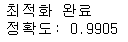

#### RMSPropOptimizer 의 정확도
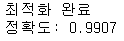

### 모든 계층에서 Dropout 수행
- 최적화 함수 RMSPropOptimizer 사용
- 손실함수 softmax_cross_entropy_with_logits_v2 사용
- L1,L2,L3 모든 층에서 70% Dropout 사용

In [25]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# MNIST 데이터 로드
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # 입력층 [입력데이터개수][28][28][특징의 개수] MNIST 데이터는 회색조 이미지라 채널에 색상이 한개이다.
Y = tf.placeholder(tf.float32, [None, 10]) # 출력 (10개의 분류)
keep_prob = tf.placeholder(tf.float32) # 드롭아웃

W1 = tf.Variable(tf.random_normal([3,3,1,32],stddev=0.01))
L1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME') # padding='SAME' : 이미지의 가장 외곽에서 한칸 밖으로 움직이는 옵션 테두리까지 정확하게 평가가능
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME') #  strides=[1,2,2,1]:슬라이딩시 두칸씩 움직이겠다.
L1 = tf.nn.dropout(L1,keep_prob)

W2 = tf.Variable(tf.random_normal([3,3,32,64],stddev=0.01)) # 32는 첫 번째 컨볼루션 계층의 커널 개수, 출력층의 개수, 첫번째 컨볼루션 계층이 찾아낸 이미지의 특징 개수
L2 = tf.nn.conv2d(L1,W2,strides=[1,1,1,1],padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
L2 = tf.nn.dropout(L2,keep_prob)

W3 = tf.Variable(tf.random_normal([7*7*64,256],stddev=0.01))
L3 = tf.reshape(L2, [-1,7*7*64]) # 직전풀링 계층의 크기가 7x7x64이므로 7x7x64의 1차원 계층으로 만듬
L3 = tf.matmul(L3,W3)
L3 = tf.nn.relu(L3)
L3 = tf.nn.dropout(L3,keep_prob)

W4 = tf.Variable(tf.random_normal([256,10],stddev=0.01))
model = tf.matmul(L3,W4)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
#optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
optimizer = tf.train.RMSPropOptimizer(0.001,0.9).minimize(cost)

# 학습 시작
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)

for epoch in range(15):
    total_cost = 0
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape(-1,28,28,1)
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob:0.7})
        
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch +1),'Avg. cost =','{:.3f}'.format(total_cost / total_batch))

print('최적화 완료')

# 결과 확인
is_correct = tf.equal(tf.argmax(model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도:', sess.run(accuracy, feed_dict={X:mnist.test.images.reshape(-1,28,28,1),Y:mnist.test.labels,keep_prob: 1}))

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 Avg. cost = 0.930
Epoch: 0002 Avg. cost = 0.122
Epoch: 0003 Avg. cost = 0.083
Epoch: 0004 Avg. cost = 0.067
Epoch: 0005 Avg. cost = 0.056
Epoch: 0006 Avg. cost = 0.051
Epoch: 0007 Avg. cost = 0.046
Epoch: 0008 Avg. cost = 0.043
Epoch: 0009 Avg. cost = 0.040
Epoch: 0010 Avg. cost = 0.039
Epoch: 0011 Avg. cost = 0.035
Epoch: 0012 Avg. cost = 0.036
Epoch: 0013 Avg. cost = 0.031
Epoch: 0014 Avg. cost = 0.032
Epoch: 0015 Avg. cost = 0.034
최적화 완료
정확도: 0.9918


### Dropout 적용 계층 수에따른 정확도 차이
- 최적화 함수 RMSPropOptimizer 사용
- 손실함수 softmax_cross_entropy_with_logits_v2 사용
- Dropout 비율은 0.7

#### L3계층에서만 사용
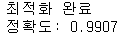

#### 모든계층에서 사용
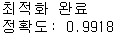

### 커널 개수 변경
- 최적화 함수 RMSPropOptimizer 사용
- 손실함수 softmax_cross_entropy_with_logits_v2 사용
- L1,L2,L3 모든 층에서 70% Dropout 사용
- 커널개수 첫번째계층 `32->64`개로 두번째계층 `64->128`개로

In [28]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# MNIST 데이터 로드
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # 입력층 [입력데이터개수][28][28][특징의 개수] MNIST 데이터는 회색조 이미지라 채널에 색상이 한개이다.
Y = tf.placeholder(tf.float32, [None, 10]) # 출력 (10개의 분류)
keep_prob = tf.placeholder(tf.float32) # 드롭아웃

W1 = tf.Variable(tf.random_normal([3,3,1,64],stddev=0.01))
L1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME') # padding='SAME' : 이미지의 가장 외곽에서 한칸 밖으로 움직이는 옵션 테두리까지 정확하게 평가가능
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME') #  strides=[1,2,2,1]:슬라이딩시 두칸씩 움직이겠다.
L1 = tf.nn.dropout(L1,keep_prob)

W2 = tf.Variable(tf.random_normal([3,3,64,128],stddev=0.01)) # 32는 첫 번째 컨볼루션 계층의 커널 개수, 출력층의 개수, 첫번째 컨볼루션 계층이 찾아낸 이미지의 특징 개수
L2 = tf.nn.conv2d(L1,W2,strides=[1,1,1,1],padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
L2 = tf.nn.dropout(L2,keep_prob)

W3 = tf.Variable(tf.random_normal([7*7*128,512],stddev=0.01))
L3 = tf.reshape(L2, [-1,7*7*128]) 
L3 = tf.matmul(L3,W3)
L3 = tf.nn.relu(L3)
L3 = tf.nn.dropout(L3,keep_prob)

W4 = tf.Variable(tf.random_normal([512,10],stddev=0.01))
model = tf.matmul(L3,W4)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
#optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
optimizer = tf.train.RMSPropOptimizer(0.001,0.9).minimize(cost)

# 학습 시작
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)

for epoch in range(15):
    total_cost = 0
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape(-1,28,28,1)
        
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob:0.7})
        
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch +1),'Avg. cost =','{:.3f}'.format(total_cost / total_batch))

print('최적화 완료')

# 결과 확인
is_correct = tf.equal(tf.argmax(model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도:', sess.run(accuracy, feed_dict={X:mnist.test.images.reshape(-1,28,28,1),Y:mnist.test.labels,keep_prob: 1}))

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 Avg. cost = 0.842
Epoch: 0002 Avg. cost = 0.075
Epoch: 0003 Avg. cost = 0.051
Epoch: 0004 Avg. cost = 0.039
Epoch: 0005 Avg. cost = 0.035
Epoch: 0006 Avg. cost = 0.030
Epoch: 0007 Avg. cost = 0.027
Epoch: 0008 Avg. cost = 0.024
Epoch: 0009 Avg. cost = 0.023
Epoch: 0010 Avg. cost = 0.022
Epoch: 0011 Avg. cost = 0.022
Epoch: 0012 Avg. cost = 0.019
Epoch: 0013 Avg. cost = 0.019
Epoch: 0014 Avg. cost = 0.018
Epoch: 0015 Avg. cost = 0.016
최적화 완료
정확도: 0.9921


### 커널 수에따른 정확도 차이
- 최적화 함수 RMSPropOptimizer 사용
- 손실함수 softmax_cross_entropy_with_logits_v2 사용
- Dropout 비율은 0.7, 모든계층에 적용

#### 첫 번째 계층 32, 두 번째 계층 64개의 커널 정확도
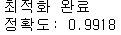

#### 첫 번째 계층 64, 두 번째 계층 128개의 커널 정확도
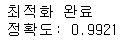

- 학습시간이 체감상 4배이상 걸린 것 같지만 후자의 경우 3번째 Epoch까지 손실값이 큰폭으로 감소했고, 정확도도 조금 더 향상됬다.

### 정확도가 가장 높았던 결과
- 최적화 함수 RMSPropOptimizer 사용
- 손실함수 softmax_cross_entropy_with_logits_v2 사용
- Dropout 비율은 0.7, 모든계층에 적용
- 첫 번째 계층 64, 두 번째 계층 128개의 커널 정확도

#### 과적합인지 판별할 수 있는 방법을 알아봐야겠다.